# Metabolomics data analysis
**Zach Flinkstrom**\
*The purpose of this notebook is to analyze the peak height data from targeted metabolomics of water extractable metabolites from the depth-sectioned wetland soil cores*\
\
**Notebook Outline:**
* Load and clean peak height data
* Perform PCA on data
* Perform statistics on compound data across depths
* Plot most correlated compounds

In [1]:
# Import required packages
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
from statsmodels.stats.multitest import fdrcorrection
from random import sample
from scipy.stats import normaltest, norm, kruskal, spearmanr
from skbio.stats import distance, ordination
from scipy.spatial.distance import pdist, squareform

/mnt/c/Users/Zach_Flinkstrom/Documents/ubuntu/.conda/envs/wetland_study/lib/python3.12/site-packages/numpy/_core/getlimits.py:548: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


## Load and clean data

In [2]:
# Load in peak height data
neg = pd.read_csv('data/metabolomics/NEG_peak_height.tab', sep='\t', skiprows=[0,1])
pos = pd.read_csv('data/metabolomics/POS_peak_height.tab', sep='\t', skiprows=[0,1])

In [3]:
#Make sure the sample names line up in pos and neg dataframes
for i in range(len(neg.columns)):
    assert(neg.columns[i][4:] == pos.columns[i][4:])

In [4]:
# Join the data from positive and negative run modes
pos.columns = neg.columns
df = pd.concat([neg.iloc[3:, :], pos.iloc[3:,:]], axis=0, ignore_index=True)
df

,short groupname,FPS_ISTD,FPS_ISTD.1,FPS_ISTD.2,FPS_ISTD.3,FPS_ISTD.4,FPS_ISTD.5,FPS_ISTD.6,FPS_ISTD.7,FPS_ISTD.8,...,NEG_LW3-Mid-WaterEx.2,NEG_LW3-Mid-WaterEx.3,NEG_LW3-Top-MeOHEx,NEG_LW3-Top-MeOHEx.1,NEG_LW3-Top-MeOHEx.2,NEG_LW3-Top-MeOHEx.3,NEG_LW3-Top-WaterEx,NEG_LW3-Top-WaterEx.1,NEG_LW3-Top-WaterEx.2,NEG_LW3-Top-WaterEx.3
0,0000_omega-hydroxydodecanoic_acid_negative_M-H...,9.322020312e+04,1.147195312e+05,8.229915625e+04,8.456588281e+04,9.354208594e+04,9.696080469e+04,8.366299219e+04,9.339714844e+04,1.148747891e+05,...,3.848979688e+05,4.706176562e+05,2.232507500e+05,2.709159688e+05,2.248307031e+05,3.416941875e+05,5.691265625e+05,9.284509375e+05,4.444353750e+05,4.743700938e+05
1,0001_thymine_negative_M-H125p0356_1p25,6.304230957e+03,8.803401367e+03,NaN,NaN,6.708729492e+03,7.239905762e+03,5.248071289e+03,NaN,6.201767090e+03,...,3.780591750e+06,1.195263300e+07,8.938404000e+06,1.740737750e+06,1.104630600e+07,1.064207800e+07,1.237986600e+07,1.860514600e+07,2.531885250e+06,2.288089600e+07
2,0002_32-hydroxyphenyl_propanoic_acid_negative_...,NaN,8.929715820e+03,4.328385254e+03,5.270741699e+03,7.935835449e+03,8.054546875e+03,5.317367676e+03,NaN,9.261026367e+03,...,2.832028125e+05,4.679638750e+05,2.199589688e+05,1.510711562e+05,2.126656719e+05,2.347665469e+05,4.602926250e+05,3.139956875e+05,2.237384062e+05,1.759452969e+05
3,0003_ferulic_acid_negative_M-H193p0506_1p30,NaN,7.048004883e+03,8.053270508e+03,4.330854492e+03,NaN,6.697770996e+03,4.065094971e+03,1.019637012e+04,5.450621094e+03,...,3.893637812e+05,2.397183906e+05,1.742715781e+05,3.396459375e+05,1.779848438e+05,3.594135000e+05,8.193235156e+04,2.102730469e+05,6.991542188e+04,1.139278672e+05
4,0004_uracil_negative_M-H111p0200_1p38,9.910674805e+03,1.464986133e+04,8.346533203e+03,5.909782715e+03,1.047164746e+04,3.522168457e+03,7.117312500e+03,7.090634277e+03,7.989774414e+03,...,8.263616000e+06,2.070409400e+07,2.307853600e+07,4.323202000e+06,2.709610800e+07,2.672394400e+07,2.841017000e+07,4.136959600e+07,4.939521500e+06,4.700584400e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,0085_glutamic_acid_positive_M+H148p0605_15p87,9.089337500e+05,8.671857500e+05,8.271026250e+05,7.412678125e+05,8.601204375e+05,7.674344375e+05,7.691376875e+05,7.836503125e+05,8.921377500e+05,...,6.142715500e+06,1.230959000e+07,2.100558500e+06,1.052191625e+06,2.869902250e+06,2.000660125e+06,2.224702000e+07,4.600211600e+07,3.664909000e+06,1.988067400e+07
185,0086_aspartic_acid_positive_M+H134p0448_16p08,1.348528281e+05,1.406589062e+05,9.792489062e+04,9.520420312e+04,1.214767109e+05,1.025094531e+05,1.037797500e+05,1.036916719e+05,9.434121094e+04,...,3.037488125e+05,9.018905625e+05,1.099698281e+05,1.119711172e+05,1.215670703e+05,1.140203438e+05,5.080086562e+05,1.535061375e+06,2.108230625e+05,2.280237188e+05
186,0087_stachyose_positive_M+Na689p2111_16p64,5.519400879e+03,NaN,4.477583496e+03,4.181676270e+03,4.175057129e+03,NaN,5.351838867e+03,NaN,5.338590332e+03,...,2.781845312e+04,2.929421680e+04,3.860884688e+05,4.812518750e+04,2.355119688e+05,3.153610938e+05,5.718135156e+04,7.572778125e+04,2.259565625e+04,3.363627734e+04
187,0088_arginine_positive_M+H175p1190_16p88,2.814632250e+06,2.712646250e+06,2.141935750e+06,2.298728000e+06,2.552990750e+06,2.483264750e+06,2.333831000e+06,2.412388250e+06,2.191784250e+06,...,2.825992500e+06,2.802259000e+06,2.759778750e+06,2.573532750e+06,2.697399000e+06,2.607230500e+06,7.165816500e+06,8.881749000e+06,2.373696500e+06,2.595668250e+06


In [5]:
#Parsing out compound names so they look nice for plotting
compounds = df.iloc[:, 0].str.split('_', expand=True)
tmp = []
for i in range(len(compounds.index)):
    word = compounds.iloc[i, 1]
    for j in [2,3,4,5]:
        if (compounds.iloc[i,j]=='positive')|(compounds.iloc[i,j]=='negative'):
            word += ' '+compounds.iloc[i, j]
            break
        else:
            word += ' '+compounds.iloc[i, j]
    tmp.append(word)
compounds = tmp

In [6]:
# Filter out internal standards columns
data = df.iloc[:,df.columns.str.contains('WaterEx')]
data.fillna(0., inplace=True)
data = data.astype('float')
data.index = compounds
data

/tmp/ipykernel_5516/813551869.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.fillna(0., inplace=True)


,NEG_ExCtrl-WaterEx,NEG_ExCtrl-WaterEx.1,NEG_ExCtrl-WaterEx.2,NEG_LW3-Btm-WaterEx,NEG_LW3-Btm-WaterEx.1,NEG_LW3-Btm-WaterEx.2,NEG_LW3-Btm-WaterEx.3,NEG_LW3-Mid-WaterEx,NEG_LW3-Mid-WaterEx.1,NEG_LW3-Mid-WaterEx.2,NEG_LW3-Mid-WaterEx.3,NEG_LW3-Top-WaterEx,NEG_LW3-Top-WaterEx.1,NEG_LW3-Top-WaterEx.2,NEG_LW3-Top-WaterEx.3
omega-hydroxydodecanoic acid negative,4.973852e+04,3.869917e+04,6.614248e+04,5.235444e+05,4.242344e+05,4.698857e+05,3.183728e+05,5.110056e+05,6.096991e+05,3.848980e+05,4.706177e+05,5.691266e+05,9.284509e+05,4.444354e+05,4.743701e+05
thymine negative,9.424237e+04,4.945804e+04,1.367981e+04,9.170444e+06,1.672506e+06,1.044724e+06,2.745342e+06,1.986552e+07,9.355549e+06,3.780592e+06,1.195263e+07,1.237987e+07,1.860515e+07,2.531885e+06,2.288090e+07
32-hydroxyphenyl propanoic acid negative,1.638318e+04,1.284766e+04,1.360721e+04,4.399522e+05,3.977673e+05,7.006182e+05,8.588016e+05,2.136611e+05,3.446717e+05,2.832028e+05,4.679639e+05,4.602926e+05,3.139957e+05,2.237384e+05,1.759453e+05
ferulic acid negative,5.353294e+03,6.027529e+03,8.396266e+03,7.132293e+04,2.508087e+05,6.309884e+04,6.645365e+04,2.356731e+05,1.132955e+05,3.893638e+05,2.397184e+05,8.193235e+04,2.102730e+05,6.991542e+04,1.139279e+05
uracil negative,2.328997e+05,1.102964e+05,3.688688e+04,1.728811e+07,2.080364e+06,1.223482e+06,5.559090e+06,4.297912e+07,1.859059e+07,8.263616e+06,2.070409e+07,2.841017e+07,4.136960e+07,4.939522e+06,4.700584e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
glutamic acid positive,8.815084e+05,8.906663e+05,7.986873e+05,9.812879e+06,1.785155e+06,3.070378e+06,1.886089e+06,3.235781e+07,1.359478e+07,6.142716e+06,1.230959e+07,2.224702e+07,4.600212e+07,3.664909e+06,1.988067e+07
aspartic acid positive,1.037466e+05,1.144171e+05,1.134382e+05,3.330418e+05,2.530994e+05,3.427717e+05,2.419434e+05,3.102353e+05,4.503458e+05,3.037488e+05,9.018906e+05,5.080087e+05,1.535061e+06,2.108231e+05,2.280237e+05
stachyose positive,4.926874e+03,0.000000e+00,0.000000e+00,4.249501e+04,2.115726e+04,1.106461e+04,1.851105e+04,5.518381e+04,4.598084e+04,2.781845e+04,2.929422e+04,5.718135e+04,7.572778e+04,2.259566e+04,3.363628e+04
arginine positive,2.116519e+06,2.196398e+06,2.143578e+06,2.060023e+06,2.677004e+06,2.046502e+06,2.475137e+06,3.588875e+06,2.750338e+06,2.825992e+06,2.802259e+06,7.165816e+06,8.881749e+06,2.373696e+06,2.595668e+06


In [7]:
# Filter out compounds that do not have detection above 2x the highest extraction control
for i in data.index:
    if np.max(data.loc[i][0:3])*2 > np.max(data.loc[i][3:]):
        print("Dropped "+i)
        data.drop(i, inplace=True)

Dropped ribitol negative
Dropped xylitol negative
Dropped arabitol negative
Dropped isocitric acid negative
Dropped malic acid negative
Dropped nicotinamide positive
Dropped sphinganine positive
Dropped betaine positive
Dropped bis 3-aminopropyl amine positive


In [8]:
# Filter out extraction control columns
data = data.iloc[:, data.columns.str.contains('LW3')]
data

,NEG_LW3-Btm-WaterEx,NEG_LW3-Btm-WaterEx.1,NEG_LW3-Btm-WaterEx.2,NEG_LW3-Btm-WaterEx.3,NEG_LW3-Mid-WaterEx,NEG_LW3-Mid-WaterEx.1,NEG_LW3-Mid-WaterEx.2,NEG_LW3-Mid-WaterEx.3,NEG_LW3-Top-WaterEx,NEG_LW3-Top-WaterEx.1,NEG_LW3-Top-WaterEx.2,NEG_LW3-Top-WaterEx.3
omega-hydroxydodecanoic acid negative,5.235444e+05,4.242344e+05,4.698857e+05,3.183728e+05,5.110056e+05,6.096991e+05,3.848980e+05,4.706177e+05,5.691266e+05,9.284509e+05,4.444354e+05,4.743701e+05
thymine negative,9.170444e+06,1.672506e+06,1.044724e+06,2.745342e+06,1.986552e+07,9.355549e+06,3.780592e+06,1.195263e+07,1.237987e+07,1.860515e+07,2.531885e+06,2.288090e+07
32-hydroxyphenyl propanoic acid negative,4.399522e+05,3.977673e+05,7.006182e+05,8.588016e+05,2.136611e+05,3.446717e+05,2.832028e+05,4.679639e+05,4.602926e+05,3.139957e+05,2.237384e+05,1.759453e+05
ferulic acid negative,7.132293e+04,2.508087e+05,6.309884e+04,6.645365e+04,2.356731e+05,1.132955e+05,3.893638e+05,2.397184e+05,8.193235e+04,2.102730e+05,6.991542e+04,1.139279e+05
uracil negative,1.728811e+07,2.080364e+06,1.223482e+06,5.559090e+06,4.297912e+07,1.859059e+07,8.263616e+06,2.070409e+07,2.841017e+07,4.136960e+07,4.939522e+06,4.700584e+07
...,...,...,...,...,...,...,...,...,...,...,...,...
glutamic acid positive,9.812879e+06,1.785155e+06,3.070378e+06,1.886089e+06,3.235781e+07,1.359478e+07,6.142716e+06,1.230959e+07,2.224702e+07,4.600212e+07,3.664909e+06,1.988067e+07
aspartic acid positive,3.330418e+05,2.530994e+05,3.427717e+05,2.419434e+05,3.102353e+05,4.503458e+05,3.037488e+05,9.018906e+05,5.080087e+05,1.535061e+06,2.108231e+05,2.280237e+05
stachyose positive,4.249501e+04,2.115726e+04,1.106461e+04,1.851105e+04,5.518381e+04,4.598084e+04,2.781845e+04,2.929422e+04,5.718135e+04,7.572778e+04,2.259566e+04,3.363628e+04
arginine positive,2.060023e+06,2.677004e+06,2.046502e+06,2.475137e+06,3.588875e+06,2.750338e+06,2.825992e+06,2.802259e+06,7.165816e+06,8.881749e+06,2.373696e+06,2.595668e+06


In [9]:
# Remove duplicate compounds (i.e. compounds that appear in both positive and negative modes, drop one of the modes)
data['compound'] = [' '.join(i[0:-1]) for i in data.index.str.split()]
data.drop_duplicates('compound', inplace=True)
data.drop('compound', axis=1, inplace=True)

/tmp/ipykernel_5516/2992586015.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['compound'] = [' '.join(i[0:-1]) for i in data.index.str.split()]
/tmp/ipykernel_5516/2992586015.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop_duplicates('compound', inplace=True)
/tmp/ipykernel_5516/2992586015.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop('comp

## PCA

In [10]:
# Perform PCA on peak height data matrix
pca = PCA(n_components=2)
scaled = StandardScaler().fit_transform(data.T)
pca_df = pd.DataFrame(pca.fit_transform(scaled), columns=['PC1', 'PC2'])
pca_df['month'] = 'May'
pca_df['sample'] = list(data.columns)
pca_df['depth'] = pca_df['sample'].str.split('-', expand=True)[1]
pca_df['depth_cm'] = pca_df.depth.map({'Top':10, 'Mid':30, 'Btm':50})
pca_df.head()

,PC1,PC2,month,sample,depth,depth_cm
0,-3.065263,4.260160,May,NEG_LW3-Btm-WaterEx,Btm,50
1,-8.421240,2.520582,May,NEG_LW3-Btm-WaterEx.1,Btm,50
2,-9.674591,3.069125,May,NEG_LW3-Btm-WaterEx.2,Btm,50
3,-8.824966,0.995123,May,NEG_LW3-Btm-WaterEx.3,Btm,50
4,7.204261,-6.102241,May,NEG_LW3-Mid-WaterEx,Mid,30


In [11]:
# Define a plotting function
def confidence_ellipse(x, y, ax, n_std=1.5, facecolor='none', **kwargs):
    """
    Source: https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

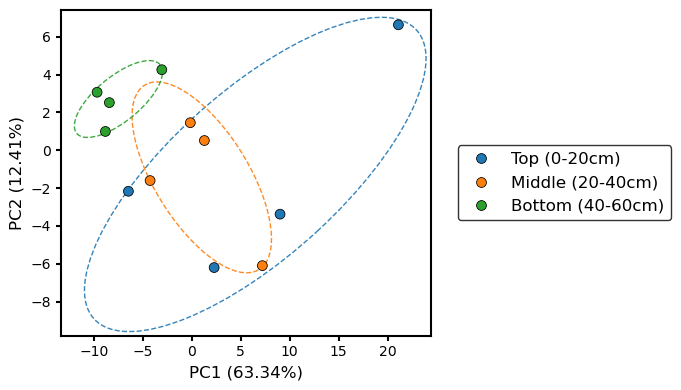

In [13]:
# Plot PCA
fig, ax = plt.subplots(1,1, figsize=(7, 4))

confidence_ellipse(pca_df[pca_df.depth=='Top']['PC1'], pca_df[pca_df.depth=='Top']['PC2'], ax, edgecolor='tab:blue', linestyle='--', alpha=0.9)
confidence_ellipse(pca_df[pca_df.depth=='Mid']['PC1'], pca_df[pca_df.depth=='Mid']['PC2'], ax, edgecolor='tab:orange', linestyle='--', alpha=0.9)
confidence_ellipse(pca_df[pca_df.depth=='Btm']['PC1'], pca_df[pca_df.depth=='Btm']['PC2'], ax, edgecolor='tab:green', linestyle='--', alpha=0.9)
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='depth', hue_order=['Top','Mid','Btm'], ax=ax, s=50, edgecolor='black', alpha=1.)

ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['top'].set_linewidth(1.5)
ax.spines['right'].set_linewidth(1.5)

ax.legend(handles = ax.get_legend_handles_labels()[0][0:3],
          labels=['Top (0-20cm)', 'Middle (20-40cm)', 'Bottom (40-60cm)'],
          fontsize=12, title_fontsize=12, edgecolor='black', bbox_to_anchor=(1.05, 0.61))

ax.tick_params(width=1.5)
plt.xticks(size=10)
plt.yticks(fontsize=10)
plt.xlabel('PC1 ({:.2f}%)'.format(pca.explained_variance_ratio_[0]*100), size=12)
plt.ylabel('PC2 ({:.2f}%)'.format(pca.explained_variance_ratio_[1]*100), size=12)
plt.tight_layout()
plt.savefig('figures/metabolomics_pca.png', dpi=450)
plt.show()

## Distance-based stats

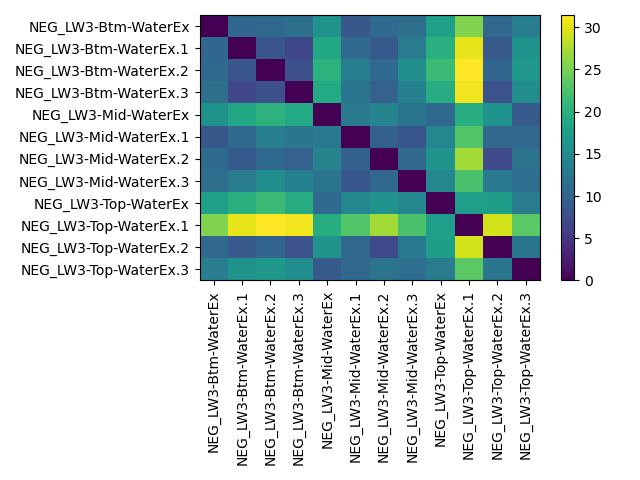

In [14]:
dist = pdist(scaled, metric='euclidean')
square_dist = squareform(dist)
dist_mat = distance.DistanceMatrix(square_dist, ids=pca_df['sample'])
dist_mat

In [15]:
distance.permanova(dist_mat, grouping=list(pca_df.depth), permutations=99999)

method name               PERMANOVA
test statistic name        pseudo-F
sample size                      12
number of groups                  3
test statistic             2.495351
p-value                      0.0428
number of permutations        99999
Name: PERMANOVA results, dtype: object

In [16]:
distance.anosim(dist_mat, grouping=list(pca_df.depth), permutations=99999)

method name                 ANOSIM
test statistic name              R
sample size                     12
number of groups                 3
test statistic            0.273148
p-value                    0.03018
number of permutations       99999
Name: ANOSIM results, dtype: object

## Stats

In [17]:
# Compute kruskal stat and spearman correlation coefficient for each compound
depth_pvals = []
depth_r = []
depth_r_p = []
for i in range(len(data.index)):
    depth_temp = kruskal(data.iloc[i, list(pca_df.depth == 'Btm')], 
                                data.iloc[i, list(pca_df.depth == 'Mid')], 
                                data.iloc[i, list(pca_df.depth == 'Top')]).pvalue
    depth_spearman = spearmanr(pca_df.depth_cm,  data.iloc[i, :], alternative = 'two-sided')
    depth_pvals.append(depth_temp)
    depth_r.append(depth_spearman.correlation)

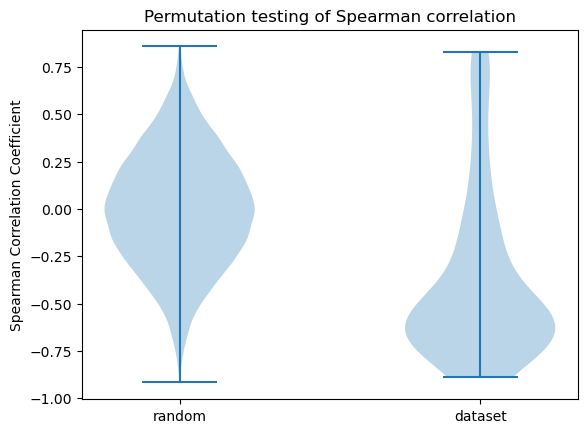

In [18]:
# Permutation test for Spearman correlation
# i.e. randomly permute depth label and compute Spearman correlation to get a null distribution
random_r = []
for j in range(100):
    for i in range(len(data.index)):
        random_depths = sample(list(pca_df.depth_cm.astype(int)), len(pca_df.depth_cm))
        random_r.append(spearmanr(random_depths, data.iloc[i,:], alternative = 'two-sided').correlation)

# Plot null distribution next to actual dataset distribution of Spearman correlation coefficients
plt.violinplot([random_r, depth_r])
plt.xticks([1,2],['random', 'dataset'])
plt.title('Permutation testing of Spearman correlation')
plt.ylabel('Spearman Correlation Coefficient')
plt.show()

In [19]:
# Print statistics related to null distribution
mu = np.mean(random_r)
sigma = np.std(random_r)
print(normaltest(random_r))
print("mean = " + str(mu))
print("std = " + str(sigma))

NormaltestResult(statistic=np.float64(88.85486914976158), pvalue=np.float64(5.0746993662716175e-20))
mean = -0.0030269567685495932
std = 0.30158863244589573


In [20]:
# Compute probability of actual dataset r values using the random null distribution
z_scores = []
p_vals = []
for i in depth_r:
    z = (i - mu)/sigma
    z_scores.append(z)
    p = norm.sf(abs(z))*2
    p_vals.append(p)

In [21]:
stats = pd.DataFrame({'compound':data.index, 'kruskal_p':depth_pvals, 'spearman_r':depth_r, 'spearman_p':p_vals})
#Add Benjamini-Hochberg p-value correction for multiple testing
stats['kruskal_pval_corr'] = fdrcorrection(stats['kruskal_p'], alpha=0.05)[1]
stats['spearman_pval_corr'] = fdrcorrection(stats['spearman_p'], alpha=0.05)[1]

In [22]:
# view stats table
stats.sort_values('spearman_pval_corr').head(50)

,compound,kruskal_p,spearman_r,spearman_p,kruskal_pval_corr,spearman_pval_corr
25,hypoxanthine negative,0.034549,-0.739140,0.014655,0.134326,0.075188
23,3-hydroxybenzoic acid negative,0.021777,0.827837,0.005870,0.134326,0.075188
21,xanthine negative,0.012468,-0.886969,0.003379,0.134326,0.075188
30,N-acetyl-methionine negative,0.019837,-0.803913,0.007918,0.134326,0.075188
19,adenine negative,0.024440,-0.739140,0.014655,0.134326,0.075188
45,N-acetyl-alanine negative,0.048839,-0.739140,0.014655,0.134326,0.075188
46,guanosine negative,0.024440,-0.739140,0.014655,0.134326,0.075188
35,inosine negative,0.023070,-0.768706,0.011123,0.134326,0.075188
40,N-acetyl-galactosamine negative,0.023070,0.768706,0.010501,0.134326,0.075188
58,uric acid negative,0.026394,-0.798272,0.008368,0.134326,0.075188


In [23]:
print("Compounds with fdr corrected spearman p-value less than 0.1: "+str(np.sum(stats.spearman_pval_corr < 0.1)))
print("Compounds with fdr corrected spearman p-value less than 0.05: "+str(np.sum(stats.spearman_pval_corr < 0.05)))

Compounds with fdr corrected spearman p-value less than 0.1: 78
Compounds with fdr corrected spearman p-value less than 0.05: 0


**After FDR correction, 78 compounds are significantly correlated with depth (but only at p < 0.1). Ultimately this analysis is constrained by small sample size (n=4 per depth) and large compound library (n=118 different compounds)**

## Compound plotting

In [24]:
# Create dataframe of standard scaled data for plotting
plot_df = pd.DataFrame(scaled)
plot_df.columns = data.index
plot_df['depth'] = list(pca_df['depth'])
plot_df

,omega-hydroxydodecanoic acid negative,thymine negative,32-hydroxyphenyl propanoic acid negative,ferulic acid negative,uracil negative,4-coumaric acid negative,vanillic acid negative,thymidine negative,syringic acid negative,2-hydroxyphenylacetic acid negative,...,4-guanidinobutanoic acid positive,glutamine positive,5-aminopentanoic acid positive,mannosamine positive,histidine positive,sn-glycero-3-phosphocholine positive,glucosamine positive,arginine positive,lysine positive,depth
0,0.087602,-0.067611,0.171570,-0.875055,-0.162047,-0.549807,-0.620047,-0.299770,0.089606,1.203519,...,1.627955,-0.416066,-0.393655,0.053559,-0.465622,-0.475501,1.079618,-0.702096,-0.616464,Btm
1,-0.590777,-1.091784,-0.046205,0.920071,-1.117340,-0.120622,-0.000677,-0.657184,-0.437748,1.203705,...,-0.455800,-0.478235,-0.859888,0.135560,-0.582850,-0.605554,1.616284,-0.405445,-0.563178,Btm
2,-0.278937,-1.177535,1.517234,-0.957308,-1.171166,-0.651099,2.534048,-1.528974,2.298762,-1.698209,...,-0.556587,-0.378279,-0.944598,0.288424,-0.637395,-0.564895,1.567511,-0.708597,-0.697751,Btm
3,-1.313911,-0.945241,2.333840,-0.923755,-0.898820,-0.174623,0.408355,-1.260620,-1.153839,-0.806668,...,-0.992635,-0.449928,-0.984413,-0.207337,-0.637141,-0.601628,0.166448,-0.502504,-0.644645,Btm
4,0.001950,1.393271,-0.996635,0.768694,1.451767,-0.555842,-0.814952,1.428979,0.352569,-0.774241,...,-0.448052,-0.218896,1.736554,-0.676393,0.015312,-0.055915,-1.006973,0.032993,0.114620,Mid
5,0.676119,-0.042327,-0.320306,-0.455267,-0.080229,-0.220931,-0.235314,0.558981,-0.762927,0.554319,...,-0.039213,-0.328438,0.000326,-0.390888,-0.262370,-0.379121,0.025793,-0.370185,-0.362551,Mid
6,-0.859482,-0.803832,-0.637633,2.305830,-0.728931,-0.316599,1.166282,-0.087751,1.698077,0.326326,...,-0.578770,-0.369023,-0.891037,-0.357539,-0.523200,-0.359148,-0.400442,-0.333809,-0.473198,Mid
7,-0.273937,0.312419,0.316178,0.809152,0.052533,-0.020927,-0.106438,1.111212,-0.706982,1.080568,...,-0.392759,-0.362165,0.191484,-0.441283,-0.307767,-0.451243,0.393716,-0.345220,-0.216833,Mid
8,0.398971,0.370776,0.276576,-0.768945,0.536600,3.173959,-0.743615,0.500795,-0.765030,-1.034181,...,0.002975,0.594562,0.731632,-0.216504,1.528431,1.277924,-0.953212,1.752826,1.459004,Top
9,2.853490,1.221111,-0.478668,0.514655,1.350662,0.407677,0.124419,1.551039,0.268924,1.035488,...,2.558027,3.187827,1.954688,3.152725,2.725384,2.880512,0.132579,2.577866,2.740275,Top


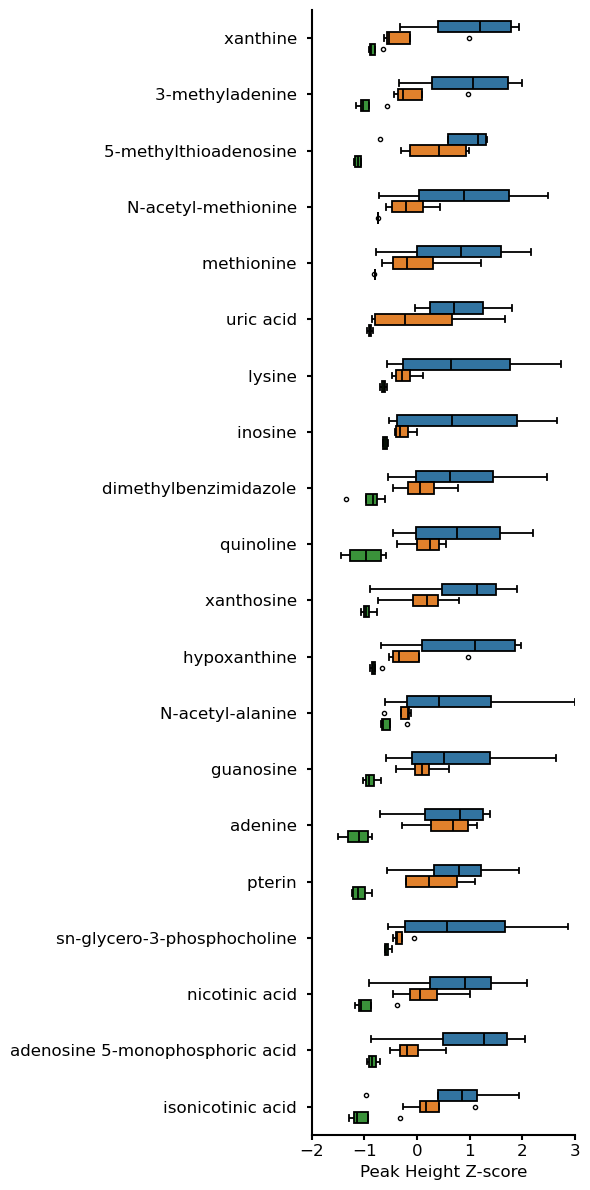

In [25]:
# Plot compounds that decrease with depth
to_plot = stats[(stats.spearman_r<0)&(stats.spearman_pval_corr < 0.1)].sort_values('spearman_r').head(20)['compound']
df2 = plot_df.melt(id_vars=['depth'], value_vars=to_plot)
df2['compound'] = df2['variable'].str.replace('negative','positive').str.split('positive', expand=True)[0]
df2['compound'] = df2['compound'].str.replace('5methylthioadenosine','5-methylthioadenosine')
df2['compound'] = df2['compound'].str.replace('adenosine 5monophosphoric acid','adenosine 5-monophosphoric acid')


fig, ax = plt.subplots(1,1, figsize=(6, 12))
g = sns.boxplot(data=df2, y='compound', x='value', hue='depth', hue_order=['Top','Mid','Btm'], dodge=True, width=.6, fliersize=3, linewidth=1.3, linecolor='black', legend=None)
sns.despine()
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.tick_params(width=1.5)
plt.yticks(rotation=0, size=12)
plt.xticks(fontsize=12)
plt.xlabel('Peak Height Z-score', size=12)
plt.ylabel('')
plt.xlim([-2,3])
plt.tight_layout()
plt.savefig('figures/metabolomics_boxplots_top.png', dpi=450)
plt.show()

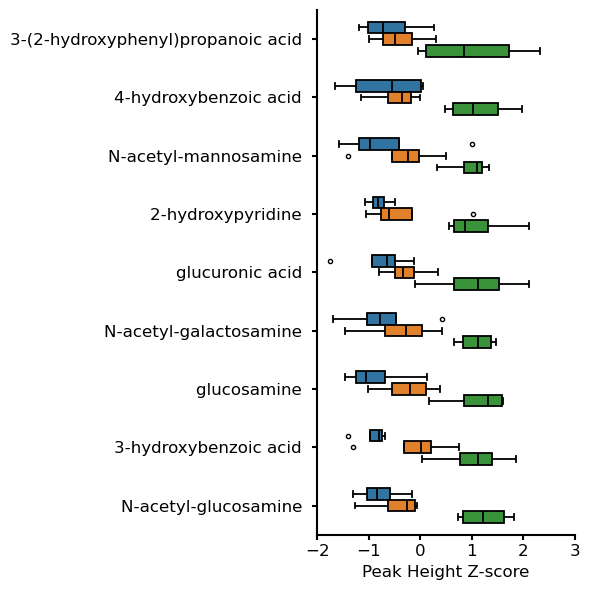

In [26]:
# Plot compounds that increase with depth
to_plot = stats[(stats.spearman_r>0)&(stats.spearman_pval_corr < 0.1)].sort_values('spearman_r')['compound']
df3 = plot_df.melt(id_vars=['depth'], value_vars=to_plot)
df3['compound'] = df3['variable'].str.replace('negative','positive').str.split('positive', expand=True)[0]
df3['compound'] = df3['compound'].str.replace('32-hydroxyphenyl propanoic acid','3-(2-hydroxyphenyl)propanoic acid')


fig, ax = plt.subplots(1,1, figsize=(6, 6))
g = sns.boxplot(data=df3, y='compound', x='value', hue='depth', hue_order=['Top','Mid','Btm'], dodge=True, width=.6, fliersize=3, linewidth=1.3, linecolor='black', legend=None)
sns.despine()
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.tick_params(width=1.5)
plt.yticks(rotation=0, size=12)
plt.xticks(fontsize=12)
plt.xlabel('Peak Height Z-score', size=12)
plt.ylabel('')
plt.xlim([-2,3])
plt.tight_layout()
plt.savefig('figures/metabolomics_boxplots_btm.png', dpi=450)
plt.show()